# Demo: Transpiling DeepMind's PerceiverIO

In this example, we will `transpile` DeepMind's original implementation of the PerceiverIO module written in JAX and build a classifier in a fully PyTorch pipeline!

## Table of Contents
* [Defining the model](#defining-the-model)
  * [Some helper functions ](#some-helper-functions)
* [Transpiling the model](#transpiling)
* [Dataset download](#dataset)
* [PyTorch pipeline](#pytorch-pipeline)
  * [DataLoader](#dataloader)
  * [Training](#training)
  * [Testing](#testing)

Let's install **Ivy** 
> if you are using Google Colab, make sure to restart your runtime before proceeding 😉



In [ ]:
# install the latest Ivy version for this purpose
!pip install git+https://github.com/unifyai/ivy.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/unifyai/ivy.git (to revision master) to /tmp/pip-req-build-tabqrujw
  Running command git clone --filter=blob:none --quiet https://github.com/unifyai/ivy.git /tmp/pip-req-build-tabqrujw
  Resolved https://github.com/unifyai/ivy.git to commit f3be3702c9fab1c9fa97c743813a4bdb39525705
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.9 MB/s eta 0:00:00
  Created wheel for ivy-core: filename=ivy_core-1.1.9-py3-none-any.whl size=1338326 sha256=e5c4205c80116b781373daf4502d61881235c5e3eb0d55096ab07dcc6eb66bec
  Stored in directory: /tmp/pip-ephem-wheel-cache

First of all, let's import **Ivy 🚀**

In [ ]:
import ivy

## Defining the model <a class="anchor" id="defining-the-model"></a>

(Psst! The PerceiverIO code we will use comes from [the original repo](https://github.com/deepmind/deepmind-research/tree/master/perceiver))

In order to use an image classifier on top of the PerceiverIO model, we must import some things first from the DeepMind repo:

In [ ]:
import torch
# utils
import os
import cv2
import pickle
import imageio
import urllib.request
# JAX imports
import jax
import jax.numpy as jnp
import numpy as np
rng = jax.random.PRNGKey(23)

In [ ]:
!pip install dm-haiku
!pip install einops

!mkdir /content/perceiver
!touch /content/perceiver/__init__.py
!wget -O /content/perceiver/io_processors.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/io_processors.py
!wget -O /content/perceiver/perceiver.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/perceiver.py
!wget -O /content/perceiver/position_encoding.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/position_encoding.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.0 MB/s eta 0:00:00
--2023-04-15 11:43:56--  https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/io_processors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29359 (29K) [text/plain]
Saving to: ‘/content/perceiver/io_processors.py’

/content/perceiver/ 100%[===================>]  28.67K  --.-KB/s    in 0.002s  

2023-04-15 11:43:56 (11.2 MB/s) - ‘/content/perceiver/io_processors.py’ saved [29359/29359]

--2023-04-15 11:43:56--  https://raw.githubusercontent.com/deepmind/deepm

##Imports 

In [ ]:
import functools
import itertools
import pickle

import cv2
import haiku as hk
import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from perceiver import perceiver, io_processors

## Model construction

We are now building an Haiku module that will be used as a backbone for our classification model. It is composed by a preprocessor that handles our input and an encoder that will output our feature vectors! 😀

In [ ]:
class PerceiverBackbone(hk.Module):
    """Perceiver image preprocessor + encoder"""

    def __init__(
        self,
        encoder,
        input_preprocessor,
        name="perceiver",
    ):
        super().__init__(name=name)

        # Feature parameters:
        self._input_preprocessor = input_preprocessor
        self._encoder = encoder

    def __call__(
        self,
        inputs,
        *,
        is_training,
        pos=None,
        input_mask=None,
    ):
        network_input_is_1d = self._encoder._input_is_1d
        inputs, _, _ = self._input_preprocessor(
            inputs,
            pos=pos,
            is_training=is_training,
            network_input_is_1d=network_input_is_1d,
        )

        # Get the queries for encoder and decoder cross-attends.
        encoder_query = self._encoder.latents(inputs)

        # Run the network forward:
        z = self._encoder(
            inputs, encoder_query, is_training=is_training, input_mask=input_mask
        )

        return z

In our case, the preprocessor is an `ImagePreprocessor` since we are dealing with images but you can change it based on your needs! 😉

In [ ]:
IMAGE_SIZE = (224, 224)

fourier_pos_configs = dict(
    input_preprocessor=dict(
        position_encoding_type="fourier",
        fourier_position_encoding_kwargs=dict(
            concat_pos=True, max_resolution=(224, 224), num_bands=64, sine_only=False
        ),
        prep_type="pixels",
        spatial_downsample=1,
    ),
    encoder=dict(
        cross_attend_widening_factor=1,
        cross_attention_shape_for_attn="kv",
        dropout_prob=0,
        num_blocks=8,
        num_cross_attend_heads=1,
        num_self_attend_heads=8,
        num_self_attends_per_block=6,
        num_z_channels=1024,
        self_attend_widening_factor=1,
        use_query_residual=True,
        z_index_dim=512,
        z_pos_enc_init_scale=0.02,
    ),
)

def perceiver_backbone(images):
    config = fourier_pos_configs
    input_preprocessor = io_processors.ImagePreprocessor(**config["input_preprocessor"])
    encoder = perceiver.PerceiverEncoder(**config["encoder"])
    model = PerceiverBackbone(encoder=encoder, input_preprocessor=input_preprocessor)
    logits = model(images, is_training=False)
    return logits

perceiver_backbone = hk.transform(perceiver_backbone)

At the end, we will get our `hk.Transformed` object that is (almost) ready to be transpiled 😎

In [ ]:
type(perceiver_backbone)

haiku._src.transform.Transformed

We also need to download the **original** parameters published by DeepMind if we want to save *some* computing 😅 

Thankfully Ivy will transform those for us as well 😉

In [ ]:
url = 'https://storage.googleapis.com/perceiver_io/imagenet_fourier_position_encoding.pystate'
!wget -O imagenet_checkpoint.pystate $url

with open('imagenet_checkpoint.pystate', 'rb') as f:
  ckpt = pickle.loads(f.read())

params = ckpt['params']

--2023-04-09 13:39:56--  https://storage.googleapis.com/perceiver_io/imagenet_fourier_position_encoding.pystate
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 74.125.31.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193776248 (185M) [application/octet-stream]
Saving to: ‘imagenet_checkpoint.pystate’

imagenet_checkpoint 100%[===================>] 184.80M   144MB/s    in 1.3s    

2023-04-09 13:39:57 (144 MB/s) - ‘imagenet_checkpoint.pystate’ saved [193776248/193776248]



## Some helper functions <a class="anchor" id="some-helper-functions"></a>

In order to correctly use the classifier, we will need to use some **preprocessing functions** (also from [the DeepMind repo](https://github.com/deepmind/deepmind-research/tree/master/perceiver))

In [ ]:
MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)
STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)


def normalize(im):
    return (im - np.array(MEAN_RGB)) / np.array(STDDEV_RGB)

def denormalize(im):
    return im * np.array(STDDEV_RGB) + np.array(MEAN_RGB)


def resize_and_center_crop(image):
    """Crops to center of image with padding then scales."""
    shape = image.shape
    image_height = shape[0]
    image_width = shape[1]
    padded_center_crop_size = (
        (224 / (224 + 32)) * np.minimum(image_height, image_width).astype(np.float32)
    ).astype(np.int32)
    offset_height = ((image_height - padded_center_crop_size) + 1) // 2
    offset_width = ((image_width - padded_center_crop_size) + 1) // 2
    crop_window = [
        offset_height,
        offset_width,
        padded_center_crop_size,
        padded_center_crop_size,
    ]
    image = image[
        crop_window[0] : crop_window[0] + crop_window[2],
        crop_window[1] : crop_window[1] + crop_window[3],
    ]
    return cv2.resize(image, (224, 224), interpolation=cv2.INTER_CUBIC)

# Transpiling the model <a class="anchor" id="transpiling"></a>

Now we are ready to transpile our backbone to PyTorch using the `ivy.transpile` function. Yes, it's that easy!
> in this case we are transpiling **eagerly** since we are passing an argument (`dummy_input`). This means that the transpiliation will take place here and the future calls of the `torch_perceiver_backbone` will be much quicker since we only need to do this once!

In [ ]:
dummy_input = jax.random.uniform(rng, shape=(1, 224, 224, 3))
torch_perceiver_backbone = ivy.transpile(perceiver_backbone, to="torch", params_v=params, kwargs={"images": dummy_input})

# PyTorch pipeline <a class="anchor" id="pytorch-pipeline"></a>

Let's define a simple PyTorch classifier that uses the just transpiled version of the PerceiverIO as a backbone!

In [ ]:
# Build a classifier using the transpiled backbone
class PerceiverIOClassifier(torch.nn.Module):
    def __init__(self, backbone, num_classes=10):
        super(PerceiverIOClassifier, self).__init__()
        self.backbone = backbone
        self.max_pool = torch.nn.MaxPool2d((512, 1))
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.backbone(images=x.permute(0, 2, 3, 1))
        x = self.flatten(self.max_pool(x))
        return self.fc(x)

# Dataset download <a class="anchor" id="dataset"></a>

We are using the HuggingFace library to download the dataset we are using for our image classifier. Of course you are free to change this to load any dataset you want 😉

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 33.1 MB/s eta 0:00:00


We are using the **WikiArt dataset**. We have images of paintings. Our goal is to classify the style of the painting!

In [ ]:
from datasets import load_dataset

N_SAMPLES = 10000
dataset = load_dataset("huggan/wikiart", split="train[:{}]".format(N_SAMPLES))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/81444 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--wikiart-36ee951979f9b56c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [ ]:
import json
!curl -X GET "https://datasets-server.huggingface.co/first-rows?dataset=huggan%2Fwikiart&config=huggan--wikiart&split=train" --output info.json
with open('info.json', 'r') as file:
    data = json.load(file)
LABELS = {i: label for i, label in enumerate(data['features'][3]['type']['names'])} 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25936  100 25936    0     0   278k      0 --:--:-- --:--:-- --:--:--  278k


In [ ]:
NUM_CLASSES = len(LABELS)
print("Number of classes: ", NUM_CLASSES)
LABELS

Number of classes:  27


{0: 'Abstract_Expressionism',
 1: 'Action_painting',
 2: 'Analytical_Cubism',
 3: 'Art_Nouveau',
 4: 'Baroque',
 5: 'Color_Field_Painting',
 6: 'Contemporary_Realism',
 7: 'Cubism',
 8: 'Early_Renaissance',
 9: 'Expressionism',
 10: 'Fauvism',
 11: 'High_Renaissance',
 12: 'Impressionism',
 13: 'Mannerism_Late_Renaissance',
 14: 'Minimalism',
 15: 'Naive_Art_Primitivism',
 16: 'New_Realism',
 17: 'Northern_Renaissance',
 18: 'Pointillism',
 19: 'Pop_Art',
 20: 'Post_Impressionism',
 21: 'Realism',
 22: 'Rococo',
 23: 'Romanticism',
 24: 'Symbolism',
 25: 'Synthetic_Cubism',
 26: 'Ukiyo_e'}

## DataLoader <a class="anchor" id="dataloader"></a>

In [ ]:
from torch.utils.data import Dataset

# Define a custom PyTorch dataset class that wraps a HugginFace
# dataset with a torch Dataset object
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['style']
        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label}

In [ ]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split

# Define the transformations to be applied to each image
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize the image to 224x224 pixels
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

dataset = CustomDataset(dataset, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
dataset_train, dataset_val, dataset_test = random_split(dataset, [train_size, val_size, test_size])


dataloader_train = DataLoader(dataset_train, batch_size=1)
dataloader_val = DataLoader(dataset_val, batch_size=1)
dataloader_test = DataLoader(dataset_test, batch_size=1)

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1])
torch.Size([224, 224, 3])


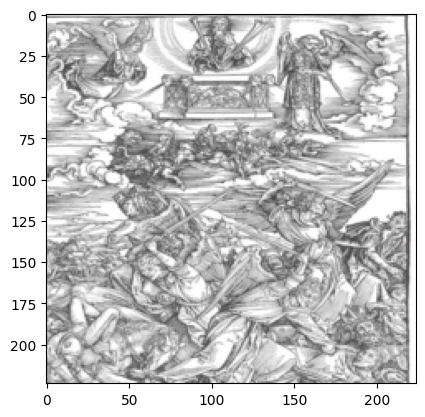

Label: Northern_Renaissance


In [ ]:
import matplotlib.pyplot as plt

batch = next(iter(dataloader_train))
train_features = batch['image']
train_labels = batch['label']
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img.permute(1, 2, 0)
print(img.shape)

plt.imshow(img)
plt.show()
print(f"Label: {LABELS[int(label)]}")

## Training <a class="anchor" id="training"></a>

In [ ]:
classifier = PerceiverIOClassifier(backbone=torch_perceiver_backbone, num_classes=NUM_CLASSES)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_step():
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(dataloader_train):
        # Every data instance is an input + label pair
        inputs, labels = data["image"], data["label"]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = classifier(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [ ]:
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    classifier.train(True)
    avg_loss = train_step()

    # We don't need gradients on to do reporting
    classifier.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(dataloader_val):
        vinputs, vlabels = vdata["image"], vdata["label"]
        voutputs = classifier(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}'.format(epoch_number)
        torch.save(classifier.state_dict(), model_path)

    epoch_number += 1

## Testing <a class="anchor" id="testing"></a>

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data["image"], data["label"]
        # calculate outputs by running images through the network
        outputs = classifier(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# Round Up

That's pretty much it! Did you have an Image Augmentation pipeline which used Kornia or some other PyTorch specific package? Maybe some complex meta-learning functions already written in Torch? Now you are free to **use, finetune, or deploy** DeepMind's PerceiverIO model and trained parameters in every framework and every hardware!